# IBM Receipt Recognition

#### Objective: Extract Total Amount, Date and Expense Type from Image of Receipt (Paper or Digital)

#### Libaries
- Gensim (word2Vec): Word Embeddings/Semantics
- SciKit Learn: Word Vectorization (ex: TF-IDF)
- Spacy, NLTK: Natural Language Processing
- TensorFlow/SciKit Learn: Machine Learning Models
- Google Cloud Vision API (OCR): Image to Json/Text Conversion
- Jupyter Notebooks: Development Environment

![alt text](test/img17.jpg "Title")

#### Steps
- Step 1: Collect a large data set of receipts, ideally both email and paper receipts. (See possible links below). This data will very likely need to be cleaned.
- Step 2: Standardization of receipt inputs. Receipt images may be slanted, tilted, or zoomed out, etc. If OCR performance is reduced because of the format of the images then we may want to find some way to standardize (remove the background and straighten out the image) for optimal OCR results.
- Step 3: Use Google OCR to convert out cleaned receipt dataset into JSON Files.
- Step 4: Use Spacy Natural Language Processing to parse JSON text. 
Finding Date and Total: Text can be parse using Regular Expressions. Create multiple spacy ‘Patterns’ to catch when parsing. 
Finding Expense Type: 
<ul>
<li>Approach 1: Load Spacy’s preloaded semantic vocabulary. Calculate the average word vector for the purchased items. Find which category(‘Food’, ‘Parking’, “Gas”) the average word vector has the least distance to.</li>
<li>Approach 2: Create a classifier (Naive Bayes, SVM, DTrees, etc) that classifies the text of common receipt types. Requires the dataset to be labelled by type. Receipt text will need to be vectorized using Scikit Learn before use of machine learning. </li>
<li>Approach 3: Ensemble Approach; use a combination of models and vector calculations to classify expense type. (Typically leads to the highest accuracy)</li>
</ul>

#### Milestones
1. Cleaned Dataset that is Large and Diverse (Contains both paper and digital receipts of various expense types)
2. Successful Image to Text Conversion
3. Date Identification
4. Total Amount Identification
5. Expense Type Identification

### Image-to-Text - Microsoft Azure Implementation - Text Detection

In [1]:
#Resource: https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts/python-print-text

In [2]:
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO

In [3]:
# Extract the word bounding boxes and text.
# Returns an Array That Contains a Dictionary with Bounding Box
# Coordinates and the Text Labels
def extract_word_info(line_infos):
    word_infos = []
    for line in line_infos:
        for word_metadata in line:
            for word_info in word_metadata["words"]:
                word_infos.append(word_info)
    return word_infos

In [4]:
# Save Output
# Saves a Text File That Contains Information of the Word Bounding Boxes and Text Labels
def save_output(word_infos, file_name="output"):
    words = []
    for i in word_infos: words.append(str(i))
    with open("text/" + file_name + ".txt", "w") as f:
        for line in words:
            f.write("%s\n" % line)

In [24]:
import json
# Save Json Output
# Saves a Text File that contains the Json Output from Microsoft Azure
def save_json(json_data, file_name="json"):
    #print(json_data)
    type(json_data)
    with open('json/' + file_name + '.txt', 'w') as outfile:
        outfile.write(json.dumps(json_data))

In [6]:
# Display the image and overlay it with the extracted text.
def create_image(image_url, word_infos, save=False, img_name="img"):
    plt.figure(figsize=(30, 30))
    image = Image.open(BytesIO(requests.get(image_url).content))
    ax = plt.imshow(image, alpha=0.5)
    for word in word_infos:
        bbox = [int(num) for num in word["boundingBox"].split(",")]
        text = word["text"]
        origin = (bbox[0], bbox[1])
        patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
        ax.axes.add_patch(patch)
        plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
    plt.axis("off")
    if save: plt.savefig('img/' + img_name + '.jpg')

In [17]:
# ENTER YOUR MICROSOFT SUBSCRIPTION KEY
# ENTER IMAGE URL
# ENTER VISION BASE (SERVER)
subscription_key = ""
image_url = ""
vision_base_url = ""

def receipt_ocr(img_id, save=True):
    img_id = str(img_id)
    print("Currently Processing: " + img_id + ".jpg")
    # Setup Key and Vision Base URL
    subscription_key = subscription_key
    assert subscription_key
    vision_base_url = vision_base_url
    ocr_url = vision_base_url + "ocr"
    # Set up API Request Parameters
    image_url = image_url + img_id + ".jpg"
    headers = {'Ocp-Apim-Subscription-Key': subscription_key}
    params  = {'language': 'unk', 'detectOrientation': 'true'}
    data    = {'url': image_url}
    response = requests.post(ocr_url, headers=headers, params=params, json=data)
    response.raise_for_status()
    analysis = response.json()
    save_json(analysis, img_id)
    # Extract Word Information form JSON
    line_infos = [region["lines"] for region in analysis["regions"]]
    word_infos = extract_word_info(line_infos)
    # Save a Txt File With Word Info
    save_output(word_infos, img_id)
    # Save the Annotated Image
    create_image(image_url, word_infos, save=save, img_name=img_id)

Currently Processing: 16.jpg
Currently Processing: 18.jpg


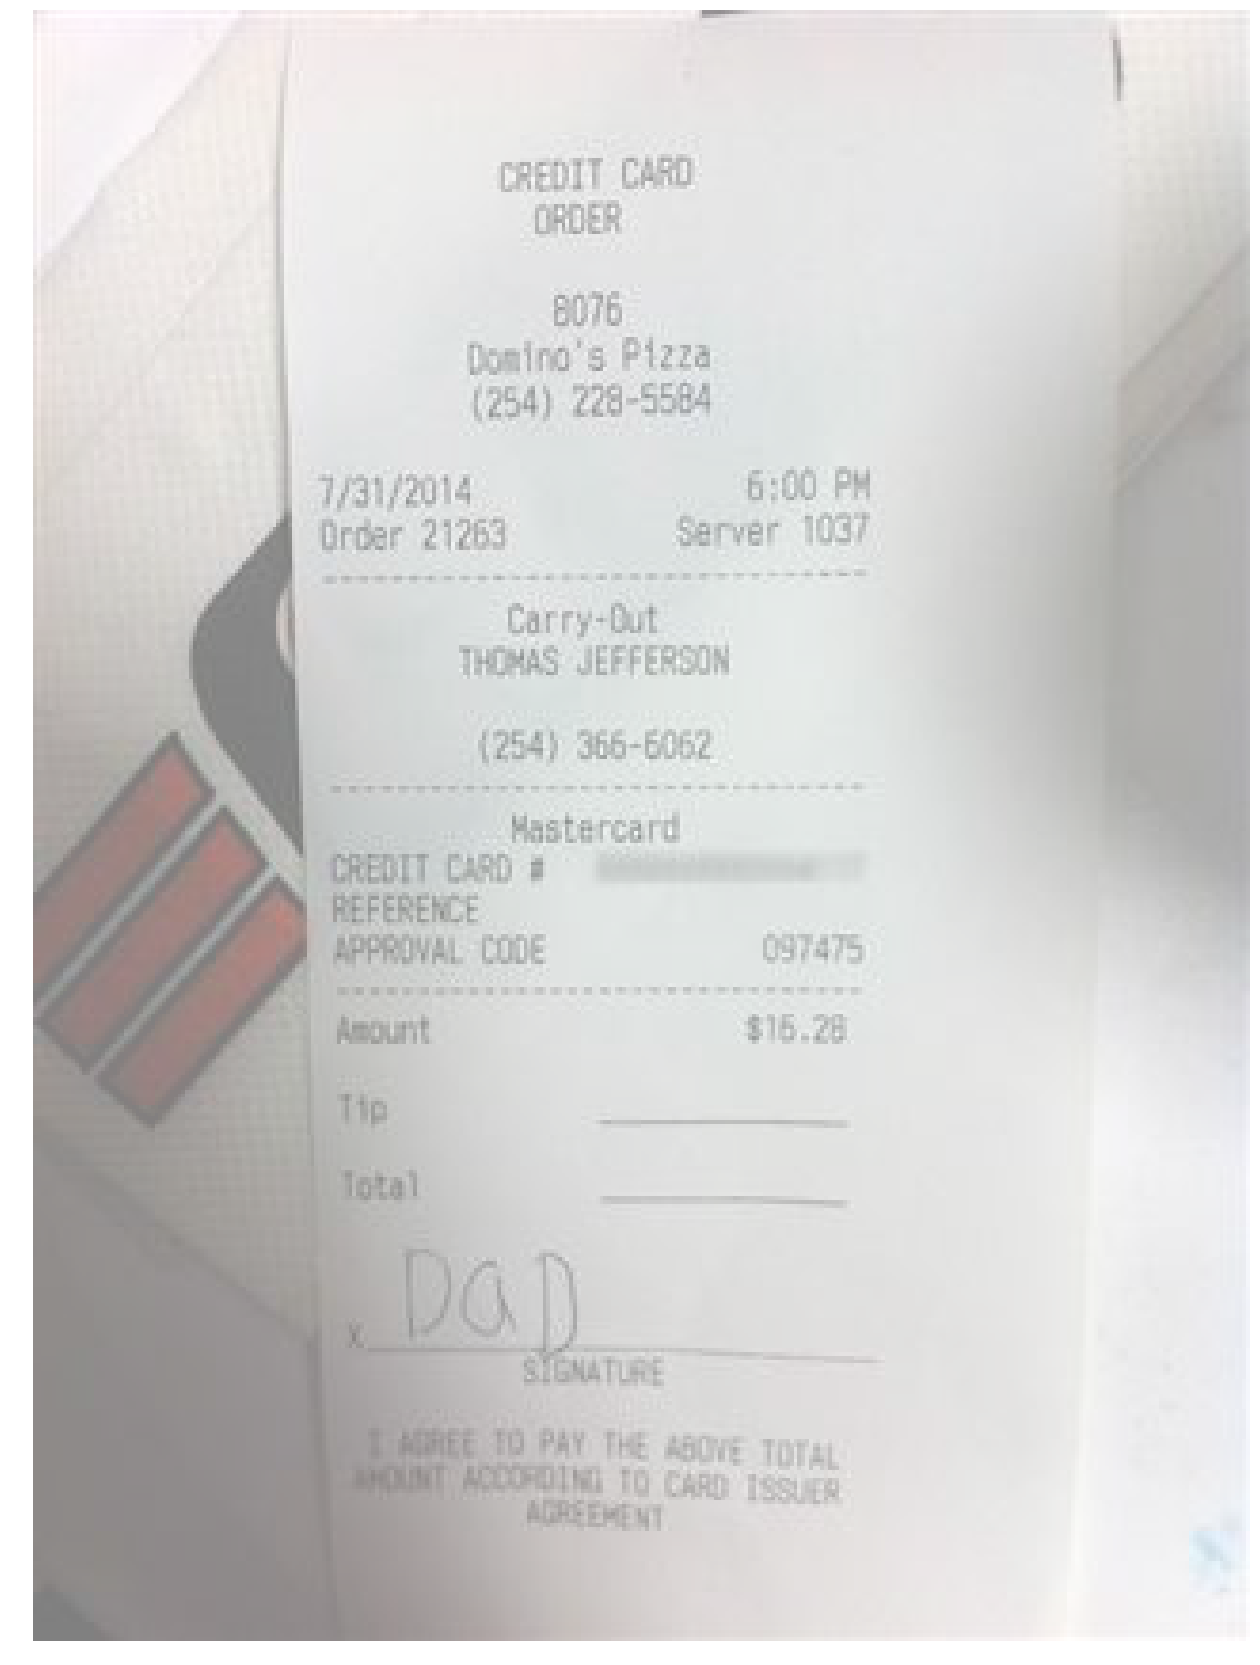

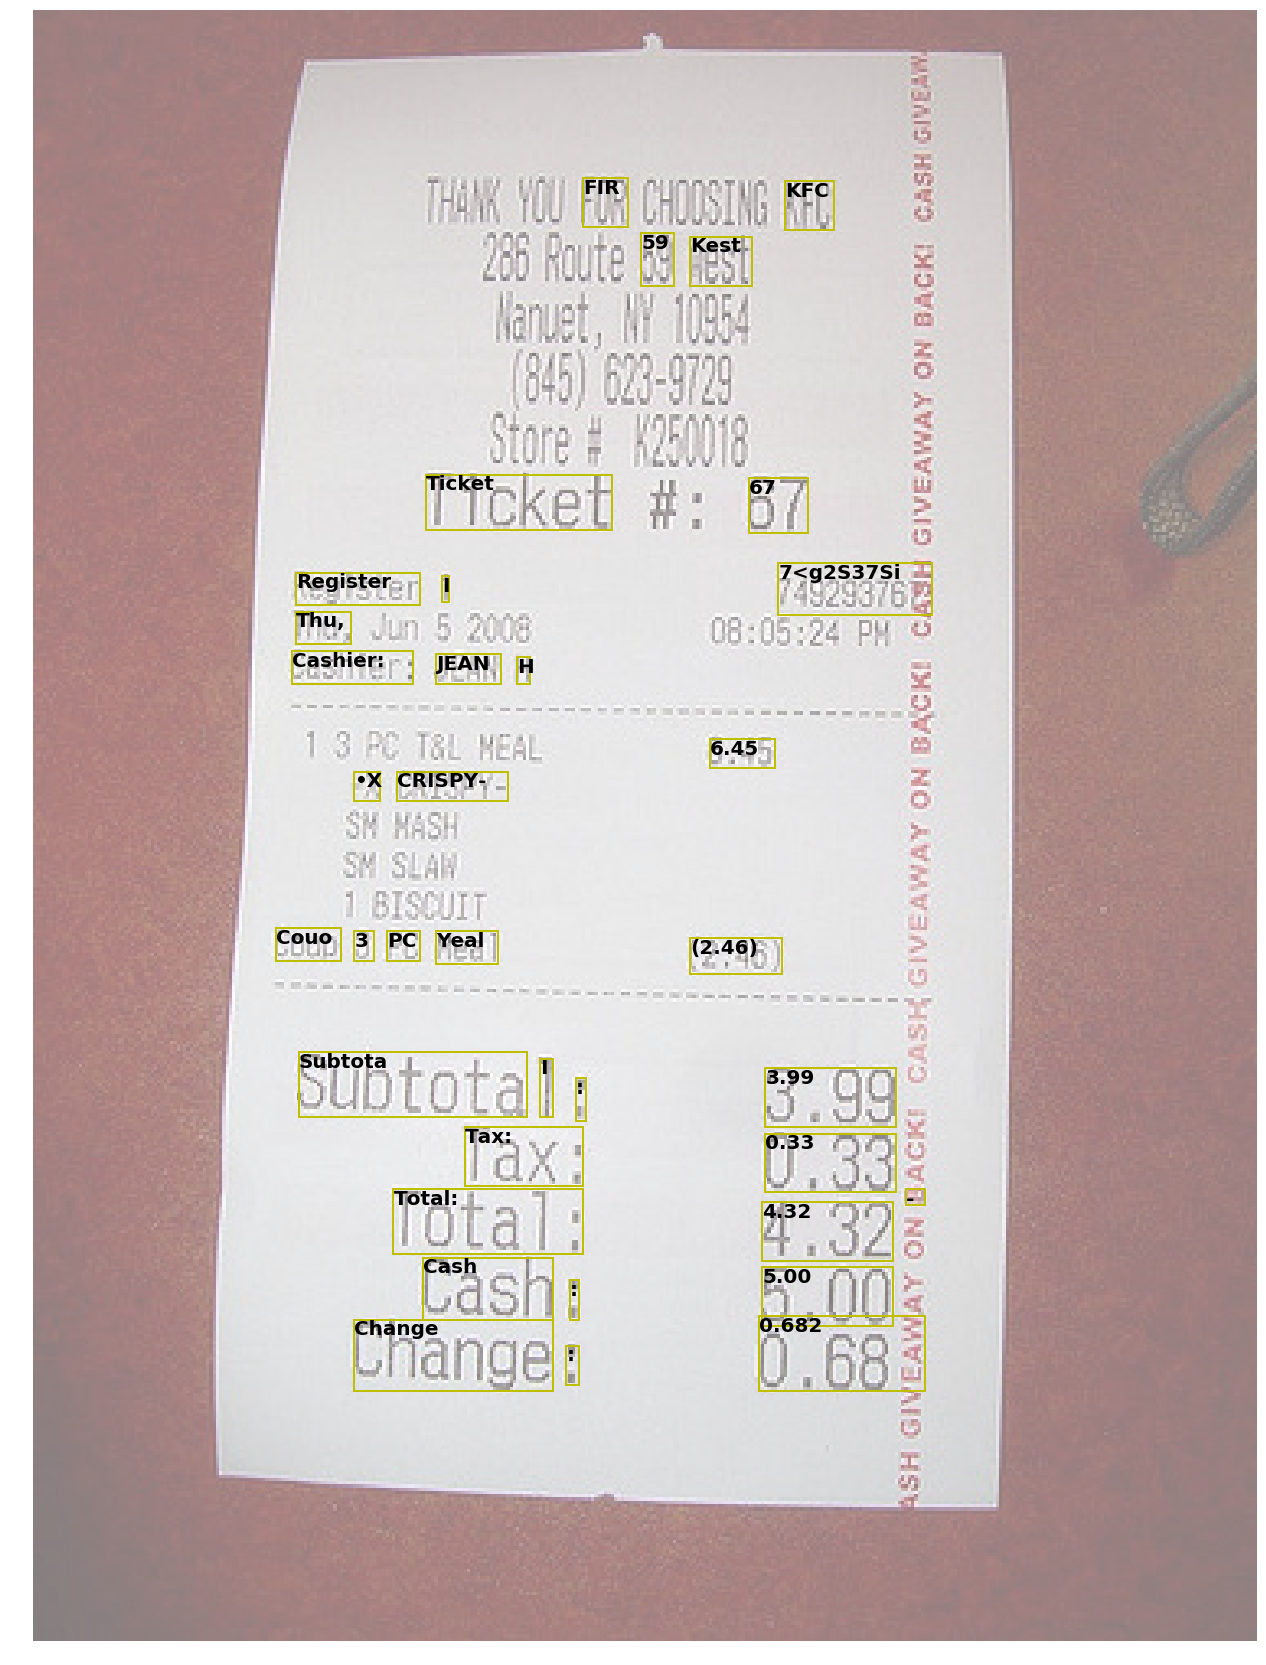

In [25]:
receipts_list = [16, 18, 19, 24, 28, 29, 33, 34, 36, 37, 38, 40, 42, 43, 45, 46, 50, 51, 52, 53]
short_list = [16, 18]
for i in receipts_list: receipt_ocr(i)